In [1]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
from escher import Builder
%matplotlib inline
import matplotlib.pyplot as plt
from vivarium.plots.topology import plot_topology

In [2]:
# Import the DynamicFBA class and the main function from the dFBA_process.py file
import sys
sys.path.append('../Models')
from dFBA_processes import DynamicFBA, main



In [16]:
# Set the desired model_path
model_path = "../SBML/e_coli_core.xml"
simulation_time = 50
# Call the main function 
data, output, processes, topology = main(model_path, simulation_time)

# Rest of the Jupyter notebook code





Simulation ID: a9308e36-e3c5-11ed-99b6-ba21c95c07d9
Created: 04/25/2023 at 20:02:40
Completed in 0.196277 seconds


In [19]:
#data

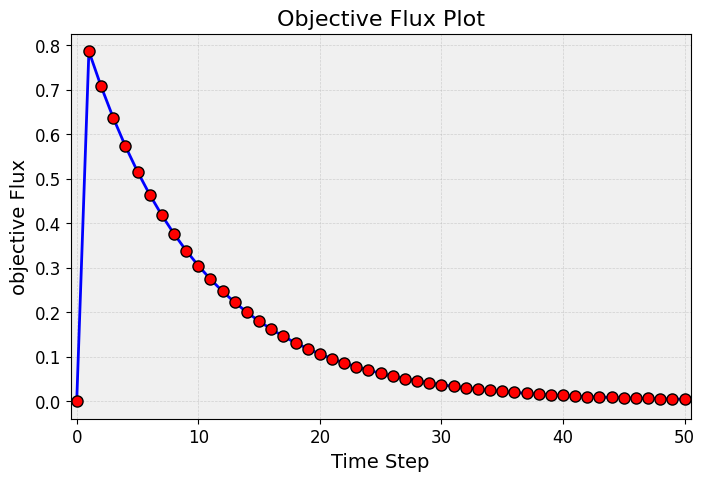

In [22]:
Time_step_data = []
objective_flux_data = []

for key, value in data.items():
    if 'objective_flux_value' in value:
        Time_step_data.append(key)
        objective_flux_data.append(value['objective_flux_value'])


plt.figure(figsize=(8, 5))  # Set the figure size
plt.plot(Time_step_data, objective_flux_data, marker='o', linestyle='-', linewidth=2, markersize=8, markerfacecolor='red', markeredgecolor='black', color='blue')

# Customize labels and title
plt.xlabel('Time Step', fontsize=14)
plt.ylabel('objective Flux', fontsize=14)
plt.title('Objective Flux Plot', fontsize=16)

# Customize the grid
plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Customize the axis limits and ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(-0.5, len(x_data)-0.5)

# Set a background color
plt.gca().set_facecolor('#f0f0f0')

plt.show()

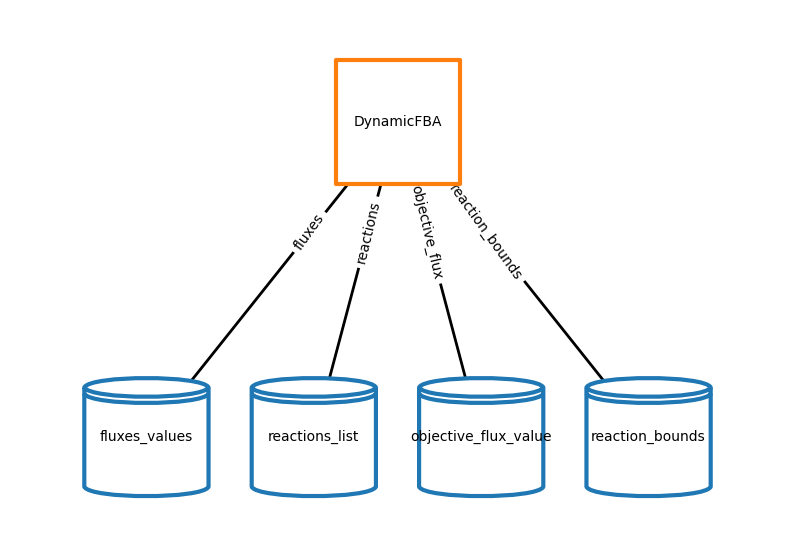

In [12]:
composite = {'processes' : processes , 'topology' : topology , 'steps' : {}, 'flow' : {}}
config ={'font_size' : 10}
fig_topology = plot_topology(composite, config)

In [ ]:
# extract the fluxes data
if isinstance(output, str):
    # convert the string to a dictionary
    output = ast.literal_eval(output)
flux_data = output[1]['fluxes_values']
reactions_data = output[1]['reactions_list']
objective_flux_data = output[1]['objective_flux_value']
reaction_bounds_data = output[1]['reaction_bounds']

#Escher
# Load the E. coli core map
builder = Builder(
    map_name="e_coli_core.Core metabolism",     #user should choose it. 
    reaction_data=flux_data,
    show_gene_reaction_rules=False,
)

# Save the Escher plot as an HTML file
builder.save_html("../Plots/escher_plot__dFBA.html")

builder